In [3]:
#import numpy, scipy, math and astropy libraries
import numpy as np
import scipy as sp
import math
import astropy
import fitsio

#import functions for reading data tables
from astropy.io import ascii, fits
from astropy.table import Table, Column, vstack

#import graphics packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.colorbar as cb
import matplotlib.colors as clrs

#set plotting defaults to values that make plots look publication ready
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 11, 7
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 11
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

#ensure that plots show up in our notebook (comment this out if converting to a script)
%matplotlib inline

### This is the original function for distance shifting a catalog

In [9]:
#create a function to append a copy of all the rows in the array, shifted to the requested distances
def add_dists(Catalog, start, end, step):
    
    #count the number of sources in the catalog
    n_sources = len(Catalog)
    
    #first calculate the distance moduli for all the stars in the catalog
    distMods = 5.*np.log10(1000./Catalog['parallax'])-5.
    
    #now save the absolute mags in each filter
    Mg = Catalog['g'] - distMods
    Mbp = Catalog['bp'] - distMods
    Mrp = Catalog['rp'] - distMods
    Mj = Catalog['j'] - distMods
    Mh = Catalog['h'] - distMods
    Mk = Catalog['k'] - distMods
    
    #now create an array of distances we want to shift the stars to
    dists = np.arange(start,end,step)
    
    #and create an array of ones with length of our catalog to multiply things by to make arrays
    makeArray = np.ones(n_sources)
    fakeIDs = np.arange(n_sources)
    toSave = Catalog
    
    for i in range(len(dists)):
        #print(a)
        thisparallax = 1000./dists[i]
        theseparallaxes = makeArray*thisparallax
        thisDistMod = 5.*np.log10(dists[i]/10.)
        theseDistMods = thisDistMod*makeArray
        fake_ids = fakeIDs+makeArray*i*10000
        NewSources = Table( [fake_ids, Catalog['ra'], Catalog['dec'], theseparallaxes, 
                             Catalog['eparallax'], Mg+theseDistMods, Catalog['eg'], Mbp+theseDistMods, Catalog['ebp'],
                             Mrp+theseDistMods, Catalog['erp'], Mj+theseDistMods, Catalog['ej'], 
                             Mh+theseDistMods, Catalog['eh'], Mk+theseDistMods, Catalog['ek'], 
                             Catalog['memb?'], Catalog['actual_gaia']], 
                             names = ('source_id', 'ra', 'dec', 'parallax', 'eparallax', 
                            'g', 'eg', 'bp', 'ebp', 'rp', 'erp', 'j', 'ej', 'h', 'eh', 'k', 'ek', 'memb?', 'actual_gaia'))
        #print(len(NewSources), len(toSave))
        #print(NewSources['g'][100], NewSources['parallax'][100], toSave['g'][100], toSave['parallax'][100])
        toSave = vstack([toSave, NewSources])
        #print(len(toSave))

        
    return toSave   

### This is the new distance shift function, which takes in a set of Sagitta outputs for where the star actually is, and shifts while preserving the inferred Av

In [11]:
#create a function to append a copy of all the rows in the array, shifted to the requested distances
def add_dists_keepAvs(Catalog, start, end, step):
    
    #count the number of sources in the catalog
    n_sources = len(Catalog)
    
    #first calculate the distance moduli for all the stars in the catalog
    distMods = 5.*np.log10(1000./Catalog['parallax'])-5.
    
    #now save the absolute mags in each filter
    Mg = Catalog['g'] - distMods
    Mbp = Catalog['bp'] - distMods
    Mrp = Catalog['rp'] - distMods
    Mj = Catalog['j'] - distMods
    Mh = Catalog['h'] - distMods
    Mk = Catalog['k'] - distMods
    
    #now create an array of distances we want to shift the stars to
    dists = np.arange(start,end,step)
    
    #and create an array of ones with length of our catalog to multiply things by to make arrays
    makeArray = np.ones(n_sources)
    fakeIDs = np.arange(n_sources)
    #toSave = Catalog
    
    for i in range(len(dists)):
        #print(a)
        thisparallax = 1000./dists[i]
        theseparallaxes = makeArray*thisparallax
        thisDistMod = 5.*np.log10(dists[i]/10.)
        theseDistMods = thisDistMod*makeArray
        fake_ids = fakeIDs+makeArray*i*10000
        NewSources = Table( [fake_ids, Catalog['ra'], Catalog['dec'], theseparallaxes, 
                             Catalog['eparallax'], Mg+theseDistMods, Catalog['eg'], Mbp+theseDistMods, Catalog['ebp'],
                             Mrp+theseDistMods, Catalog['erp'], Mj+theseDistMods, Catalog['ej'], 
                             Mh+theseDistMods, Catalog['eh'], Mk+theseDistMods, Catalog['ek'], Catalog['av'],
                             Catalog['memb?'], Catalog['actual_gaia']], 
                             names = ('source_id', 'ra', 'dec', 'parallax', 'eparallax', 
                            'g', 'eg', 'bp', 'ebp', 'rp', 'erp', 'j', 'ej', 'h', 'eh', 'k', 'ek', 'av', 'memb?', 'actual_gaia'))
        #print(len(NewSources), len(toSave))
        #print(NewSources['g'][100], NewSources['parallax'][100], toSave['g'][100], toSave['parallax'][100])
        if i == 0:
            toSave = NewSources
        else:
            toSave = vstack([toSave, NewSources])
        #print(len(toSave))

    return toSave   

In [7]:
####import Upper Sco catalog
UpperSco = fitsio.read("../TestCatalogs/J_AJ_160_44_table4.dat.fits", 
                      columns = ['Gaia', 'RAdeg', 'DEdeg', 'plx', 'e_plx', 'pmRA', 'pmDE', 'Ak', 
                                 'Gmag', 'e_Gmag', 'GBPmag', 'e_GBPmag', 'GRPmag', 'e_GRPmag', 
                                 'Jmag', 'eJmag', 'Hmag', 'eHmag', 'Ksmag', 'eKsmag', 'memb?'], ext=1)

####find the number of sources in the raw catalog
#print(len(UpperSco['Gaia']))
#print(UpperSco['plx'])

####trim the catalog to those sources with positive parallaxes (otherwise dist modulus becomes nan)
usefulParallaxes = np.nonzero(UpperSco['plx'])
#print(len(usefulParallaxes[0]))

####sagitta is complaining about duplicate GaiaIDs -- let's find them.
print(len(UpperSco['Gaia'][usefulParallaxes]), len(np.unique(UpperSco['Gaia'][usefulParallaxes])))

####since it looks like there are ~20 doubled entries, let's pull them out
uniqueIDs, indices = np.unique(UpperSco['Gaia'][usefulParallaxes], return_index=True)
#print(len(UpperSco['Gaia'][usefulParallaxes][indices]))

####save the filtered array, for convenience
#UsefulSco = UpperSco[usefulParallaxes]
#print(UsefulSco)

####convert the filtered array into the column names Sagitta wants 
####(but save the gaia ID in a different index to link results)
UsefulSco = Table( [UpperSco['Gaia'][usefulParallaxes][indices], UpperSco['RAdeg'][usefulParallaxes][indices], UpperSco['DEdeg'][usefulParallaxes][indices], 
                     UpperSco['plx'][usefulParallaxes][indices], UpperSco['e_plx'][usefulParallaxes][indices],
                     UpperSco['Gmag'][usefulParallaxes][indices], UpperSco['e_Gmag'][usefulParallaxes][indices], 
                     UpperSco['GBPmag'][usefulParallaxes][indices], UpperSco['e_GBPmag'][usefulParallaxes][indices], 
                     UpperSco['GRPmag'][usefulParallaxes][indices], UpperSco['e_GRPmag'][usefulParallaxes][indices], 
                     UpperSco['Jmag'][usefulParallaxes][indices], UpperSco['eJmag'][usefulParallaxes][indices], 
                     UpperSco['Hmag'][usefulParallaxes][indices], UpperSco['eHmag'][usefulParallaxes][indices], 
                     UpperSco['Ksmag'][usefulParallaxes][indices], UpperSco['eKsmag'][usefulParallaxes][indices], 
                     UpperSco['memb?'][usefulParallaxes][indices], UpperSco['Gaia'][usefulParallaxes][indices]], 
                     names = ('source_id', 'ra', 'dec', 'parallax', 'eparallax', 
                            'g', 'eg', 'bp', 'ebp', 'rp', 'erp', 'j', 'ej', 'h', 'eh', 'k', 'ek', 'memb?', 'actual_gaia'))
#print(len(UsefulSco))

####now write out the simple array for Sagitta to assess
UsefulSco.write('../SagittaInputs/UsefulSco.fits', format = 'fits', overwrite=True)

1817 1796


In [10]:
#now inflate with lots of distance shifted copies of itself
longerSco = add_dists(UsefulSco, 10, 500, 3)
print(len(longerSco))

#now write it out so Sagitta can assess it.
longerSco.write('../SagittaInputs/LongerSco.fits', format = 'fits', overwrite=True)

296340


In [12]:
### originally, we distance shifted the original input catalog, but now, let's also test distance shifting the 
# sagitta outputs for the input catalog, so that we can preserve the inferred Avs
UsefulSco_sagitta = fitsio.read("../SagittaOutputs/UsefulSco_results.fits", 
                                columns = ['source_id', 'ra', 'dec', 'parallax', 'eparallax', 'g', 'eg', 'bp', 'ebp',
                                     'rp', 'erp', 'j', 'ej', 'h', 'eh', 'k', 'ek', 'memb?', 'actual_gaia', 
                                     'l', 'b', 'av', 'pms', 'age', 'age_mean', 'age_median', 'age_std', 'age_var',
                                    'age_min', 'age_max'], ext=1)

longerSco = add_dists_keepAvs(UsefulSco_sagitta, 10, 500, 3)
print(len(longerSco))

#now write it out so Sagitta can assess it.
longerSco.write('../SagittaInputs/LongerSco_WithAvs.fits', format = 'fits', overwrite=True)

294544


### This is the cell that records the non-notebook work with Sagitta
the following command line command:

    > sagitta LongerSco.fits --age_uncertainty 10 --tableOut LongerSco_results.fits

produces this output:

    Loading input table
        Making dataframe from table
    Converting RA & Dec to L & B
    Predicting stellar extinctions as av
    Predicting PMS probablities as pms
    Predicting stellar ages as age
    Generating Age uncertainties with 10 samples per star
        Scattering Age model inputs
        Running the age model on the varied data
        Aggregating the age uncertainties
    Saving output table to LongerSco_results.fits
    Done

So now we just need to read in LongerSco_results.fits and do our analysis on it (as well as the initial inputs)

-----
after talking with Marina, testing if the results change if the Av values are propogated along with the distance shift.

To do that, modified the distance shift routine (as shown above), produced new LongerSco_WithAvs.fits file, and then ran sagitta as:

    sagitta LongerSco_WithAvs.fits --age_uncertainty 10 --av av --no_av_prediction 
    Loading input table
        Making dataframe from table
    Converting RA & Dec to L & B
    Predicting PMS probablities as pms
    Predicting stellar ages as age
    Generating Age uncertainties with 10 samples per star
        Scattering Age model inputs
        Running the age model on the varied data
        Aggregating the age uncertainties
    Saving output table to LongerSco_WithAvs-sagitta.fits
    Done

In [13]:
#LongerSco_outputs = fitsio.read("../SagittaOutputs/LongerSco_results.fits", <--- switch to here if you want to check
#                                                                             Sagitta's inferred Avs at each distance
LongerSco_outputs = fitsio.read("../SagittaOutputs/LongerSco_WithAvs-sagitta.fits", #<-- use constant Avs
                          columns = ['source_id', 'ra', 'dec', 'parallax', 'eparallax', 'g', 'eg', 'bp', 'ebp',
                                     'rp', 'erp', 'j', 'ej', 'h', 'eh', 'k', 'ek', 'memb?', 'actual_gaia', 
                                     'l', 'b', 'av', 'pms', 'age', 'age_mean', 'age_median', 'age_std', 'age_var',
                                    'age_min', 'age_max'], ext=1)

UsefulSco_sagitta = fitsio.read("../SagittaOutputs/UsefulSco_results.fits", 
                                columns = ['source_id', 'ra', 'dec', 'parallax', 'eparallax', 'g', 'eg', 'bp', 'ebp',
                                     'rp', 'erp', 'j', 'ej', 'h', 'eh', 'k', 'ek', 'memb?', 'actual_gaia', 
                                     'l', 'b', 'av', 'pms', 'age', 'age_mean', 'age_median', 'age_std', 'age_var',
                                    'age_min', 'age_max'], ext=1)

#### Start by investigating the properties of the Upper Sco stars at their actual distances. 

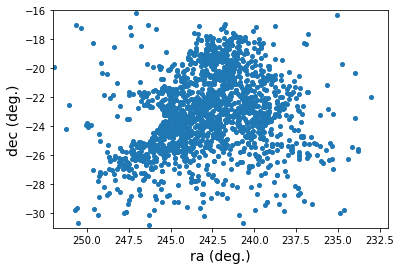

In [18]:
plt.scatter(UsefulSco_sagitta['ra'], UsefulSco_sagitta['dec'])
plt.xlabel('ra (deg.)')
plt.ylabel('dec (deg.)')
plt.xlim(252, 232)
plt.ylim(-31, -16)
plt.savefig('../plots/UpperScoFootprint.png')

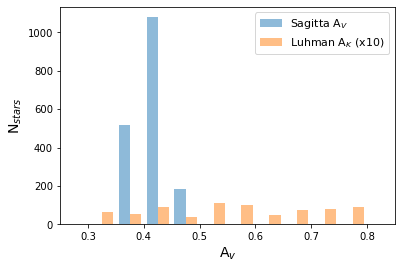

In [19]:
#### First do a couple comparisons to the properties that Luhman et al found.
n_av_bins = 10
labels = ['Sagitta A$_V$', 'Luhman A$_K$ (x10)']
n, bins, patches = plt.hist([UsefulSco_sagitta['av'],UpperSco['Ak']*10], n_av_bins, range = [0.3,0.8], alpha = 0.5, label = labels)
#n2, bins2, patches2 = plt.hist(, n_av_bins, range = [0.3,0.8], alpha = 0.5)
plt.legend()
plt.xlabel('A$_v$')
plt.ylabel('N$_{stars}$')
plt.xlim(0.25, 0.85)
plt.savefig('../plots/compareUpperScoAv.png')

In [20]:
#### divide the Luhman sample into members and non-members
members = UpperSco[UpperSco['memb?'] == 'Y']
nonmembers = UpperSco[UpperSco['memb?'] == 'N']
print(len(members), len(nonmembers))

1761 259


/Users/coveyk/opt/anaconda3/envs/sagitta/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


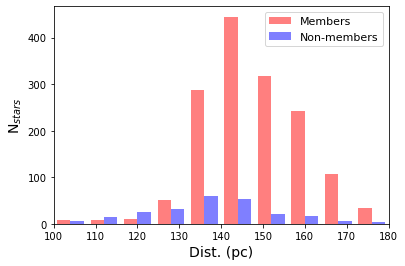

In [21]:
#### Check if there are systematic differences in the positions of members and non-members
n_dist_bins = 10
labels = ['Members', 'Non-members']
colors = ['red', 'blue']
n, bins, patches = plt.hist([1000./members['plx'],1000./nonmembers['plx']], n_dist_bins, range = [100.,180.], alpha = 0.5, label = labels, color = colors)
plt.legend()
plt.xlabel('Dist. (pc)')
plt.ylabel('N$_{stars}$')
plt.xlim(100,180)
plt.savefig('../plots/compareUpperScoDists.png')

/Users/coveyk/opt/anaconda3/envs/sagitta/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/coveyk/opt/anaconda3/envs/sagitta/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
No handles with labels found to put in legend.


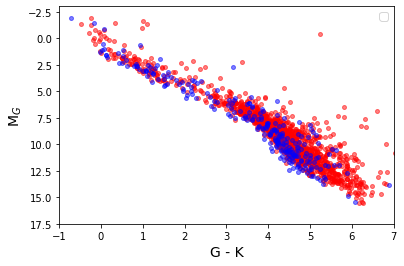

In [22]:
#### Check if there are systematic differences in the color-magnitude positions of members and non-members
labels = ['Members', 'Non-members']
colors = ['red', 'blue']
plt.scatter(members['Gmag']-members['Ksmag'], members['Gmag'] - (5.*np.log10(1000./members['plx'])-5.), alpha = 0.5, color = 'red')
plt.scatter(nonmembers['Gmag']-nonmembers['Ksmag'], nonmembers['Gmag'] - (5.*np.log10(1000./nonmembers['plx'])-5.), alpha = 0.5, color = 'blue')
plt.legend()
plt.xlabel('G - K')
plt.ylabel('M$_G$')
plt.ylim(17.5,-3)
plt.xlim(-1,7)
plt.savefig('../plots/compareUpperScoColorMag.png')

1540 256
frac. of >80% pms status: (members, nonmembers) 0.861038961038961 0.6640625


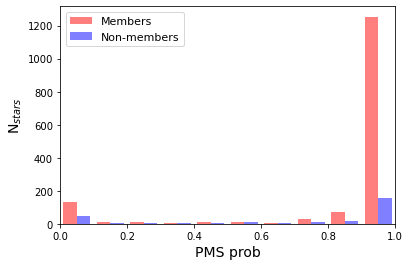

In [23]:
#### Now check the membership probabilities of the YSOs at their actual distances
n_prob_bins = 10
labels = ['Members', 'Non-members']
colors = ['red', 'blue']

members = UsefulSco_sagitta[UsefulSco_sagitta['memb?'] == 'Y']
nonmembers = UsefulSco_sagitta[UsefulSco_sagitta['memb?'] == 'N']
print(len(members), len(nonmembers))

#find action of members with prob > 80%
high_members = members[members['pms'] > 0.8]
low_members = members[members['pms'] < 0.8]

high_nonmembers = nonmembers[nonmembers['pms'] > 0.8]
low_nonmembers = nonmembers[nonmembers['pms'] < 0.8]

print('frac. of >80% pms status: (members, nonmembers)', len(high_members)/(1.*len(members)),len(high_nonmembers)/(1.*len(nonmembers)))

n, bins, patches = plt.hist([members['pms'],nonmembers['pms']], n_prob_bins, range = [0.,1.], alpha = 0.5, label = labels, color = colors)
plt.legend()
plt.xlabel('PMS prob')
plt.ylabel('N$_{stars}$')
plt.xlim(0,1)
plt.savefig('../plots/compareUpperScoProbs.png')

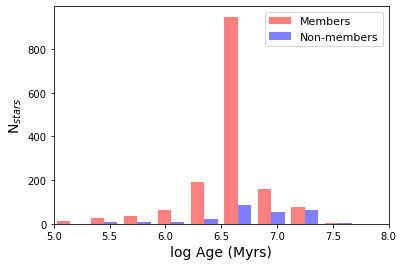

In [24]:
n_age_bins = 15.
n, bins, patches = plt.hist([members['age'],nonmembers['age']], n_prob_bins, range = [5.,8.], alpha = 0.5, label = labels, color = colors)
plt.legend()
plt.xlabel('log Age (Myrs)')
plt.ylabel('N$_{stars}$')
plt.xlim(5,8)
plt.savefig('../plots/compareUpperScoAges.png')

### Now start investigating the Sagitta parameters
#### Check the PMS probabilities of members + nonmembers

252560 41984


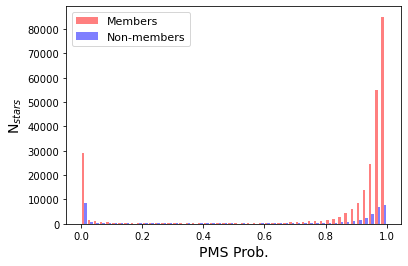

In [25]:
### start by examining the pms distributions for members and non-members
Longer_members = LongerSco_outputs[LongerSco_outputs['memb?'] == 'Y']
Longer_nonmembers = LongerSco_outputs[LongerSco_outputs['memb?'] == 'N']
print(len(Longer_members), len(Longer_nonmembers))

n_prob_bins = 50

labels = ['Members', 'Non-members']
colors = ['red', 'blue']
n, bins, patches = plt.hist([Longer_members['pms'],Longer_nonmembers['pms']], n_prob_bins, range = [0.,1.], alpha = 0.5, label = labels, color = colors)
plt.xlabel('PMS Prob.')
plt.ylabel('N$_{stars}$')
plt.legend()
plt.savefig('../plots/compareUpperScoLongerProbs.png')

#### Check the age distributions of members + non-members

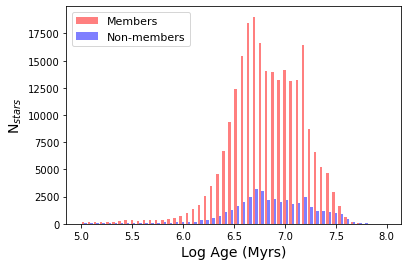

In [26]:
n_age_bins = 50

n, bins, patches = plt.hist([Longer_members['age'],Longer_nonmembers['age']], n_prob_bins, range = [5.,8.], alpha = 0.5, label = labels, color = colors)
plt.xlabel('Log Age (Myrs)')
plt.ylabel('N$_{stars}$')
plt.legend()
plt.savefig('../plots/compareUpperScoLongerAges.png')

#### check the scale of the age errors (std seems more reliable than variance?)

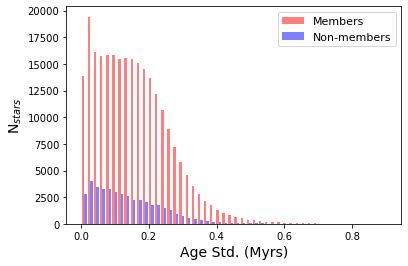

In [27]:
n_age_bins = 50

n, bins, patches = plt.hist([Longer_members['age_std'],Longer_nonmembers['age_std']], n_prob_bins, alpha = 0.5, label = labels, color = colors)
plt.xlabel('Age Std. (Myrs)')
plt.ylabel('N$_{stars}$')
plt.legend()
plt.savefig('../plots/compareUpperScoLongerAgeStd.png')

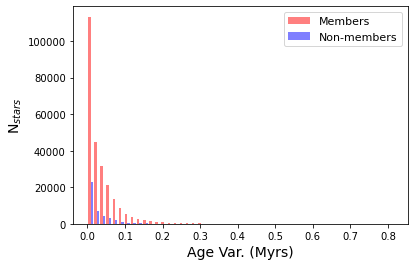

In [28]:
n, bins, patches = plt.hist([Longer_members['age_var'],Longer_nonmembers['age_var']], n_prob_bins, alpha = 0.5, label = labels, color = colors)
plt.xlabel('Age Var. (Myrs)')
plt.ylabel('N$_{stars}$')
plt.legend()
plt.savefig('../plots/compareUpperScoLongerAgeVar.png')

#### now check for distance dependence in the inferred ages and pms probabilities

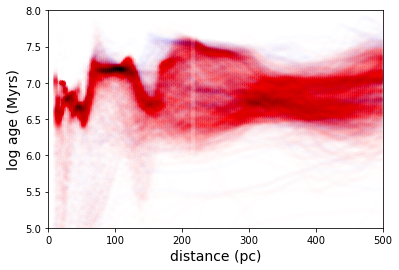

In [29]:
#### Check if there are systematic differences in inferred ages as a function of distance
labels = ['Members', 'Non-members']
colors = ['red', 'blue']
plt.scatter(1000./Longer_members['parallax'], Longer_members['age'], alpha = 0.005, color = 'red')
plt.scatter(1000./Longer_nonmembers['parallax'], Longer_nonmembers['age'], alpha = 0.005, color = 'blue')
plt.xlabel('distance (pc)')
plt.ylabel('log age (Myrs)')
plt.ylim(5,8)
plt.xlim(0,500)
plt.savefig('../plots/LongerUpperScoDistAge.png')

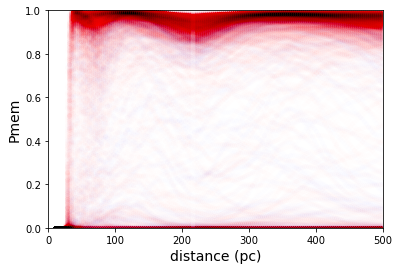

In [31]:
#### Check if there are systematic differences in the inferred membership probabilities as a function of distance
labels = ['Members', 'Non-members']
colors = ['red', 'blue']
plt.scatter(1000./Longer_members['parallax'], Longer_members['pms'], alpha = 0.005, color = 'red')
plt.scatter(1000./Longer_nonmembers['parallax'], Longer_nonmembers['pms'], alpha = 0.005, color = 'blue')
plt.xlabel('distance (pc)')
plt.ylabel('Pmem')
plt.ylim(0,1)
plt.xlim(0,500)
plt.savefig('../plots/LongerUpperScoDistPMS.png')

### Test significance of age deviations

In [33]:
#### create an array of length UsefulSco to store ratio of actual spread to quoted uncertainties
UsefulSco_length = len(UsefulSco_sagitta)
differences = np.zeros([UsefulSco_length, 164])
errors = np.zeros([UsefulSco_length, 164])
significances = np.zeros([UsefulSco_length, 164])

#### loop through the original UpperSco results
for i in range(UsefulSco_length):
        
    #find the ages of the distance shifted analogs by matching on the actual gaia id columns
    differences[i,:] = np.absolute((LongerSco_outputs['age'][LongerSco_outputs['actual_gaia'] == UsefulSco_sagitta['actual_gaia'][i]]) - UsefulSco_sagitta['age'][i])
    errors[i,:] = LongerSco_outputs['age_std'][LongerSco_outputs['actual_gaia'] == UsefulSco_sagitta['actual_gaia'][i]]
    significances[i,:] = differences[i,:]/errors[i,:]
    
print(np.median(differences),np.median(errors),np.median(significances))

0.3040201663970947 0.13862648628057117 2.1169000547101424


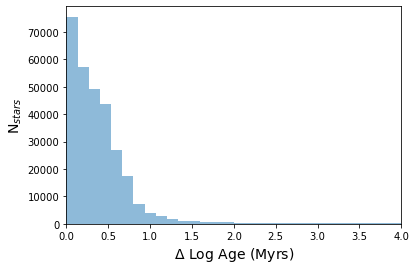

In [34]:
n_age_bins = 30
n, bins, patches = plt.hist(np.ravel(differences), n_age_bins, alpha = 0.5, range=[0,4])
plt.xlim(0,4)
plt.xlabel('$\Delta$ Log Age (Myrs)')
plt.ylabel('N$_{stars}$')
plt.savefig('../plots/compareUpperScoAgeDiffs.png')